In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

### Importing Data (and timing how long it takes)

In [5]:
s=time.time()
df = pd.read_csv('lending-club-loan-data/df_clean.csv')
e=time.time()
print('Readtime: {}'.format(e-s))

Readtime: 23.16411018371582


In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Summary Statistics:

In [7]:
summary = pd.DataFrame(df.describe().T)
summary

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1885912.0,15446.390778,9254.587496,1000.00,8000.00,14000.00,20075.00,4.000000e+04
int_rate,1885912.0,13.035871,4.853959,5.31,9.44,12.62,15.88,3.099000e+01
installment,1885912.0,455.900747,268.665548,4.93,260.52,389.01,606.93,1.719830e+03
emp_length,1885912.0,5.961357,3.720711,0.00,2.00,6.00,10.00,1.000000e+01
annual_inc,1885912.0,80688.216595,111030.505938,0.00,49721.75,68000.00,95967.25,1.100000e+08
...,...,...,...,...,...,...,...,...
rcnt_il,1885912.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.000000e+00
rcnt_bc,1885912.0,0.999999,0.001030,0.00,1.00,1.00,1.00,1.000000e+00
rcnt_bc_delinq,1885912.0,0.239483,0.426768,0.00,0.00,0.00,0.00,1.000000e+00
rcnt_inq,1885912.0,0.892076,0.310284,0.00,1.00,1.00,1.00,1.000000e+00


### A lot of the columns in the data appears to have a very high range of values but a tight IQR, this indicates that much of the data is probably heavily skewed

## Identifying all columns datatypes

In [8]:
df.dtypes.value_counts()

float64    68
object     11
int64       4
dtype: int64

### Helper fuction to extract all objects from the dataframe (I wrote this before I realized pandas had a builtin .select_dtpyes method) 

In [9]:
#creating a list of all columns from the original df
df_cols = list(df.columns)

#creating an indexed list for all columns in the df by datatype (this step is needed for the loop I'm going to write):
dtypes_enum = enumerate(df.dtypes)

#writing a loop to extract the index positions of the object columns:
obj_index_list = []
for i,j in list(dtypes_enum):
    if j == object:
        obj_index_list.append(i)


#With the list of index positions, we can extract the object columns from the df:        
object_columns = [df_cols[col] for col in obj_index_list]
df_obj = df[object_columns]    

In [10]:
#Extracting all the numeric columns:
df_num = df.select_dtypes(include='number')
numeric_columns = list(df_num.columns)

# Univariate EDA

## Exploring the data within the object columns:

In [18]:
split_points = list(range(2,10,2))
split_obj_cols = [object_columns[i : j] for i, j in zip([0] + split_points, split_points + [None])] 

### Frequency Distributions of Object columns (<51 unique values)

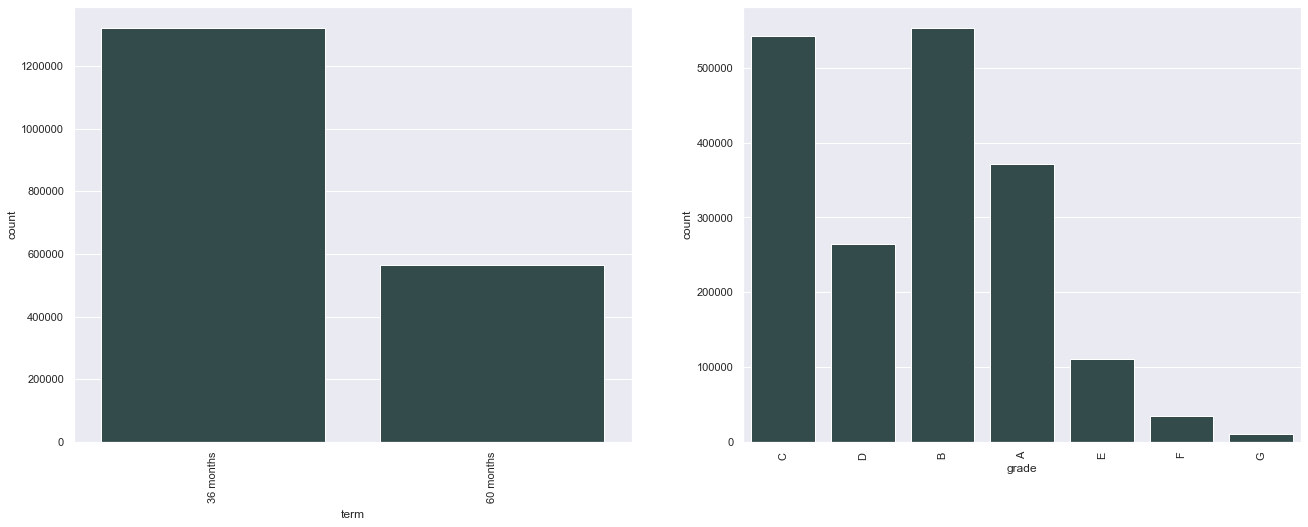

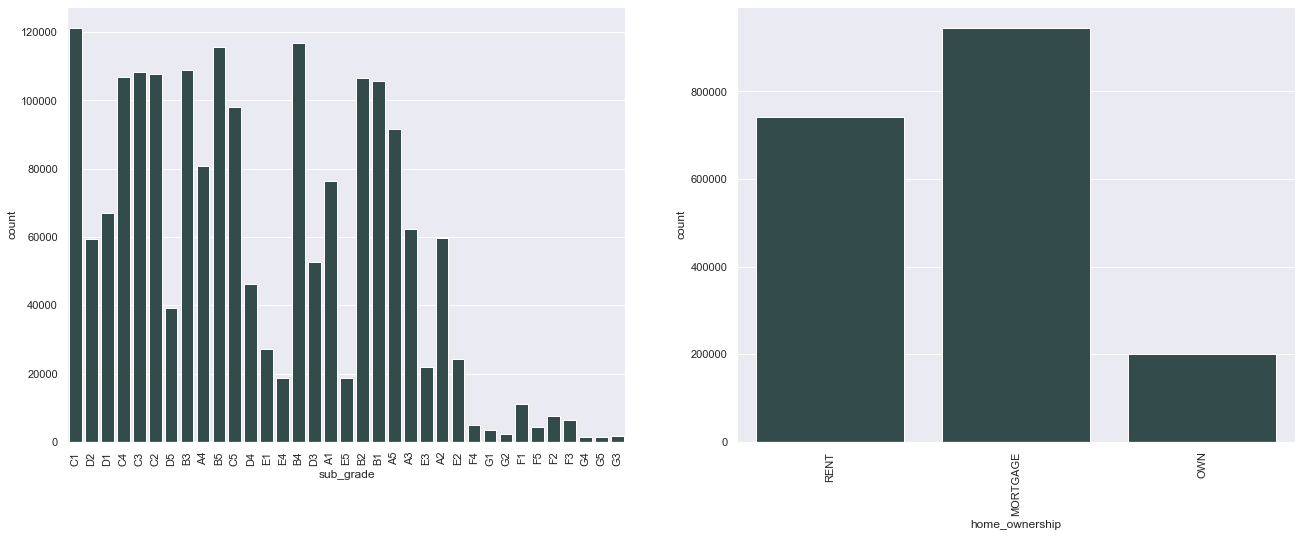

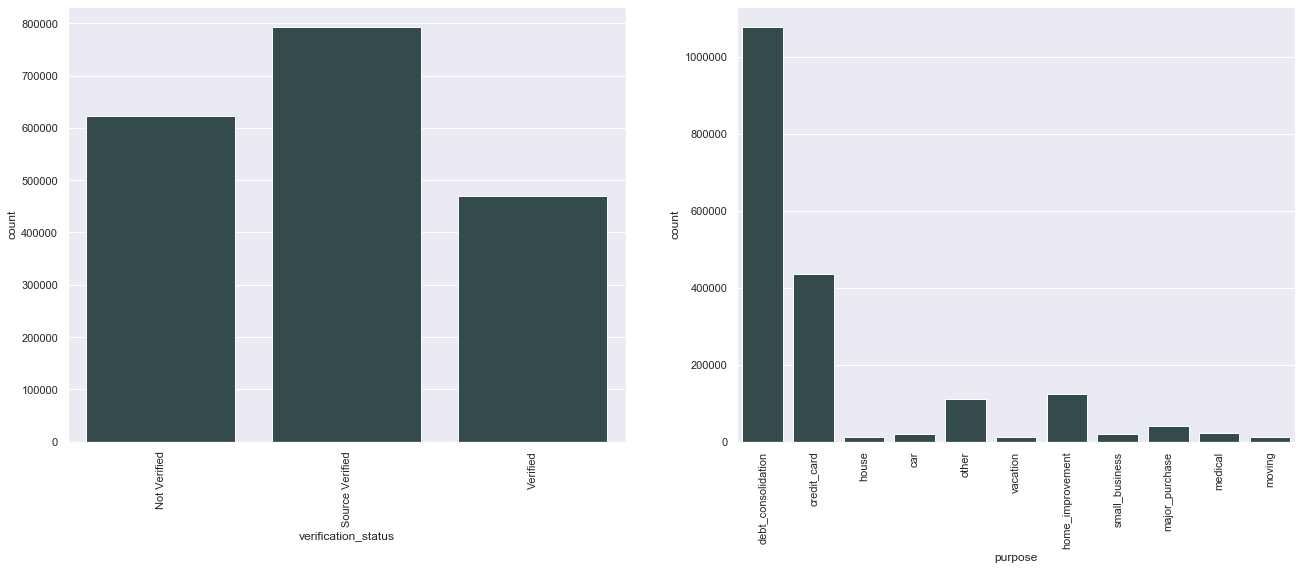

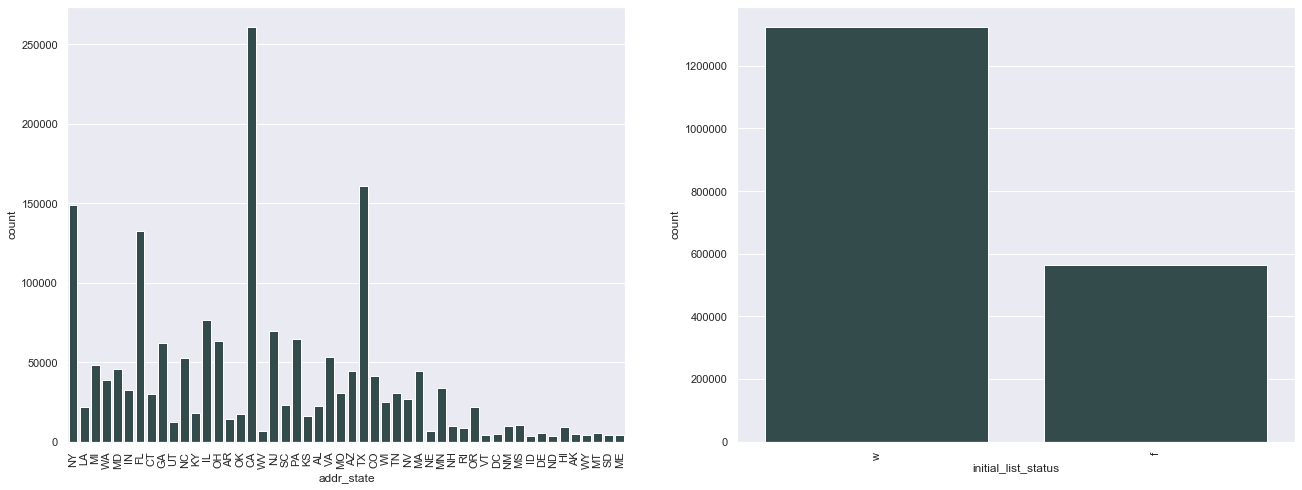

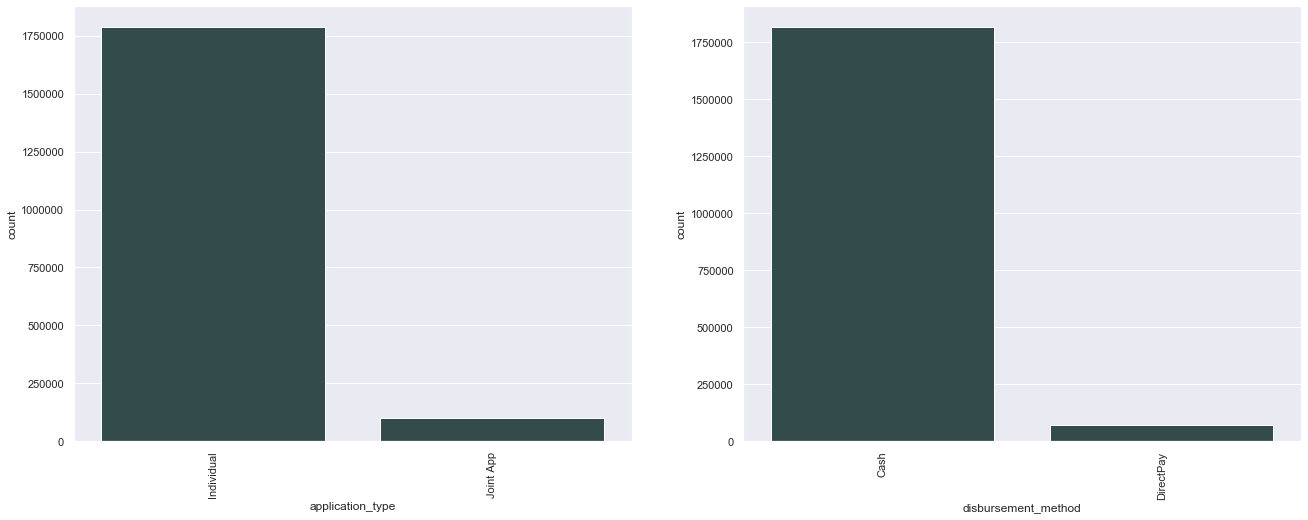

In [20]:
for i in split_obj_cols:
    fig, axes = plt.subplots(ncols=len(i), figsize=(22,8))
    for ax, col in zip(axes, i):
        sns.set(style='darkgrid')
        sns.countplot(df[col], ax=ax, color='darkslategray')
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
    plt.show()

### Most of the object columns appear to show relatively reasonable frequency distributions, with the exception of   "application_type", "disbursement_method", and "purpose"

## Exploring the data within the numeric columns:

In [26]:
len(numeric_columns)

72

In [27]:
split_points = list(range(4,72,4))
split_num_cols = [numeric_columns[i : j] for i, j in zip([0] + split_points, split_points + [None])] 

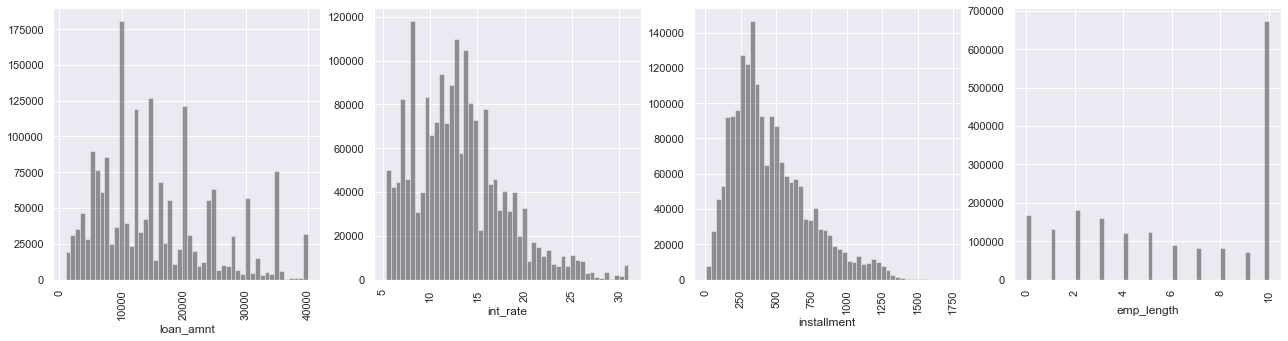

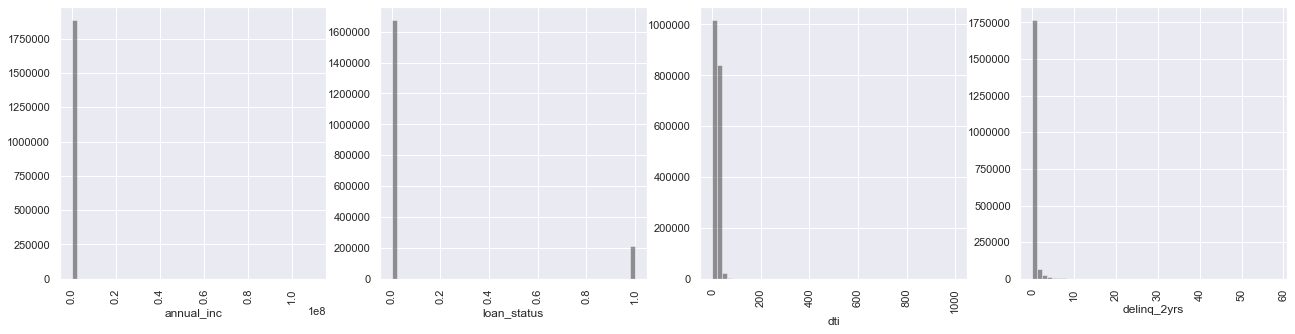

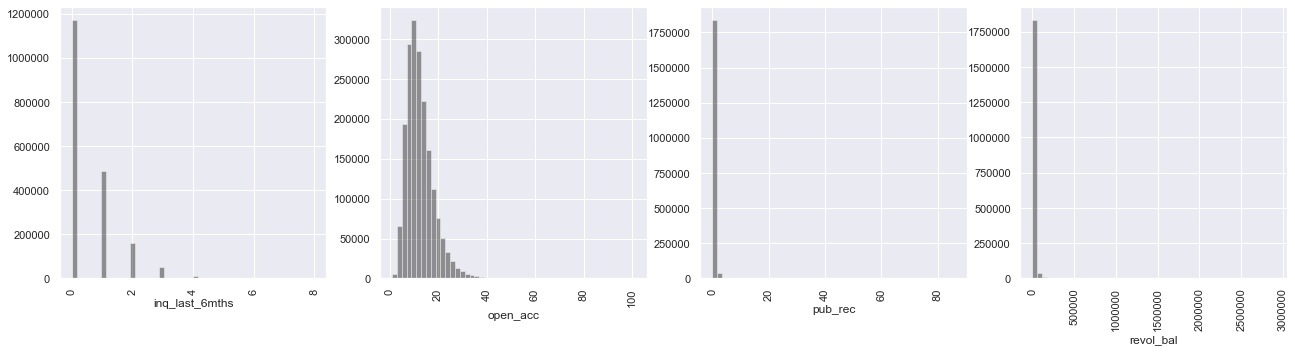

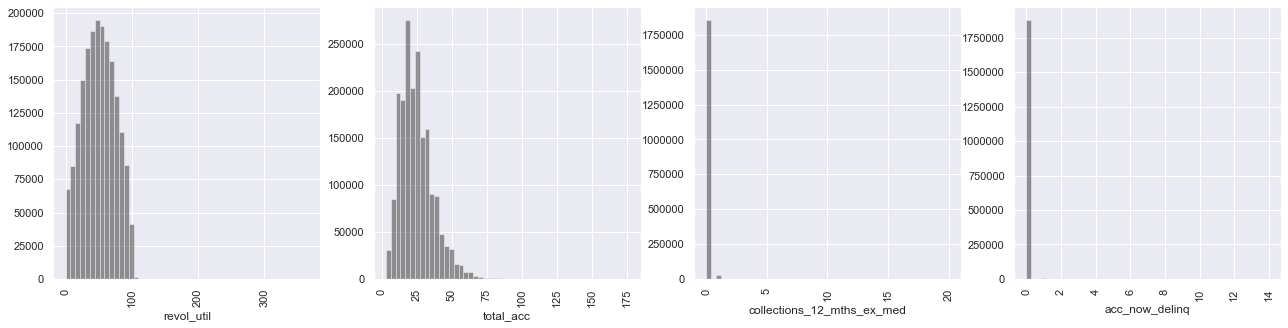

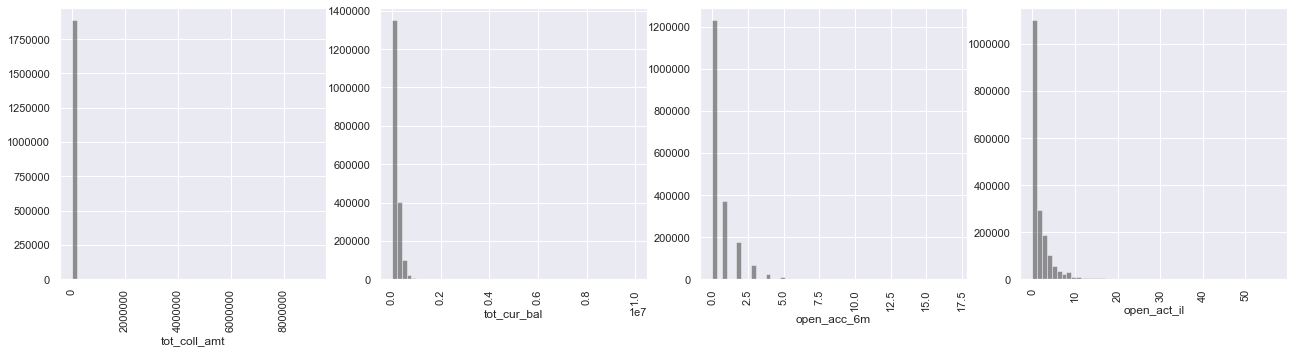

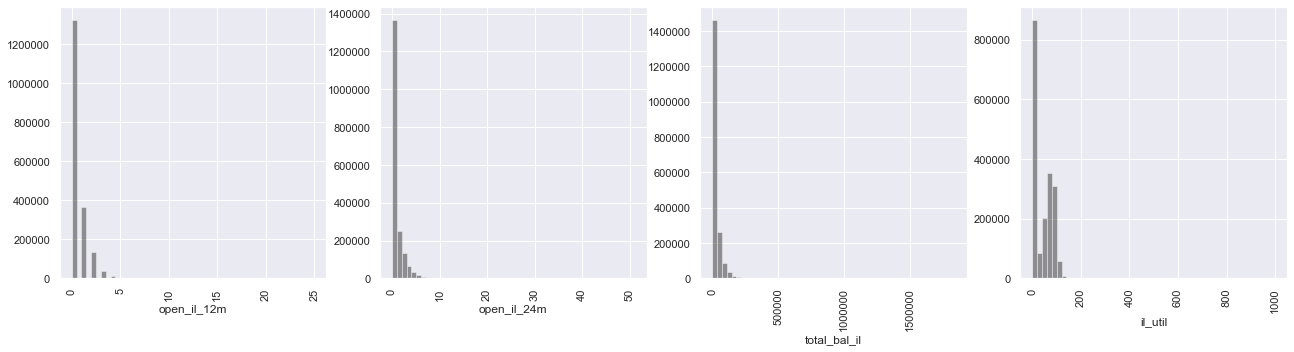

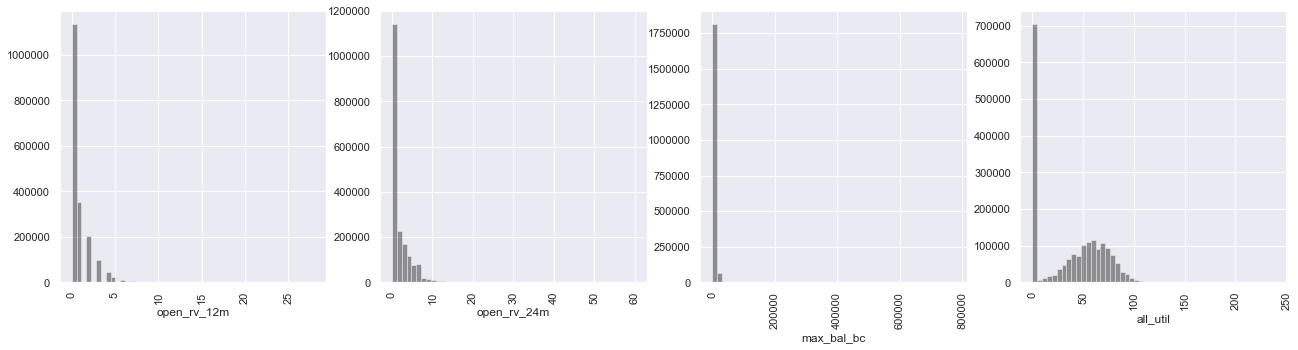

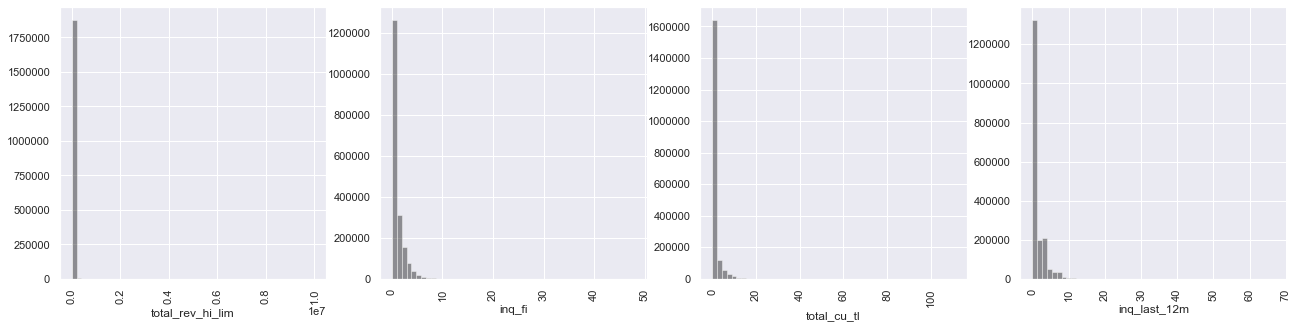

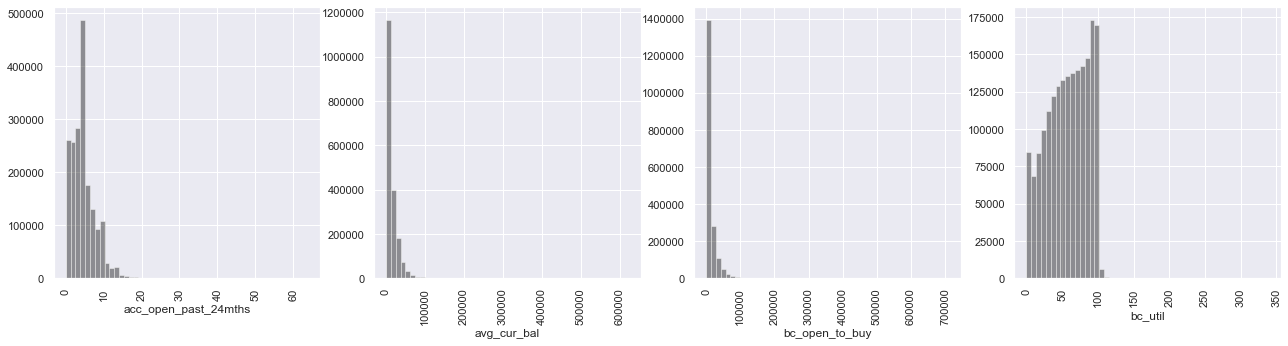

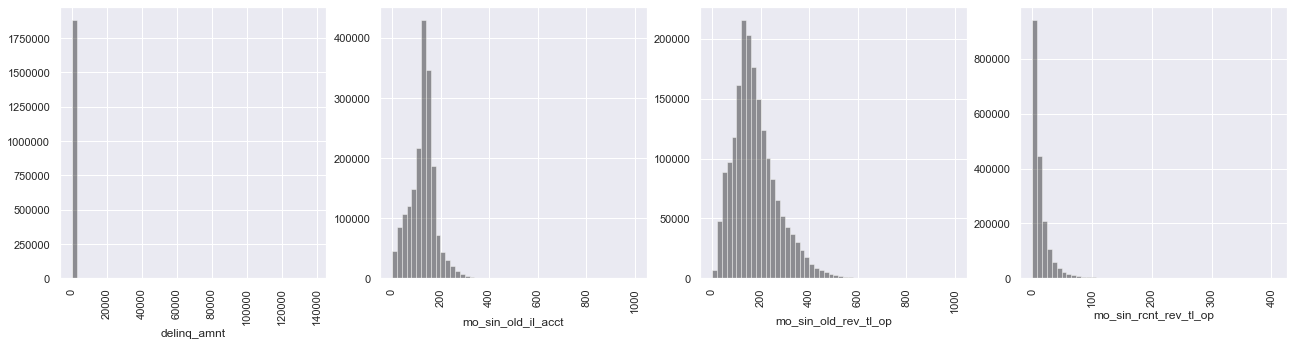

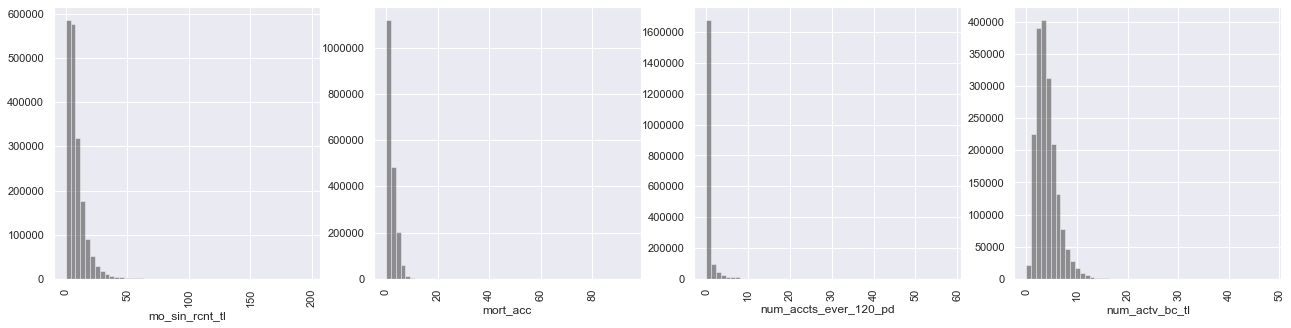

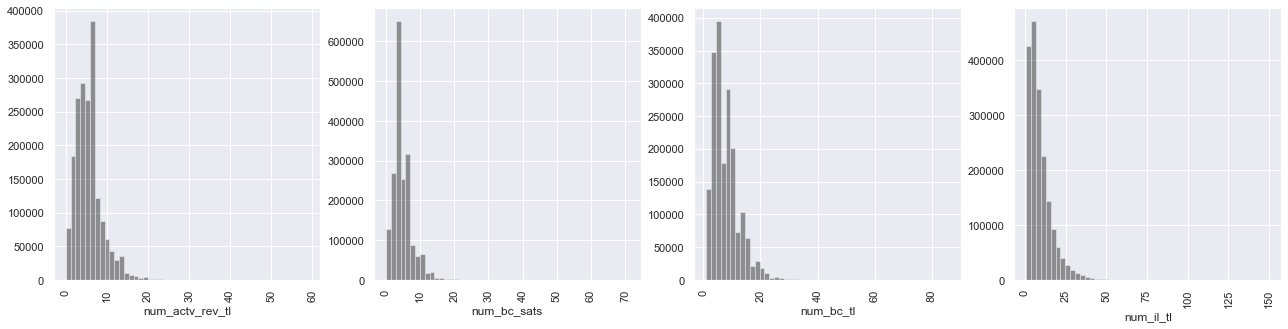

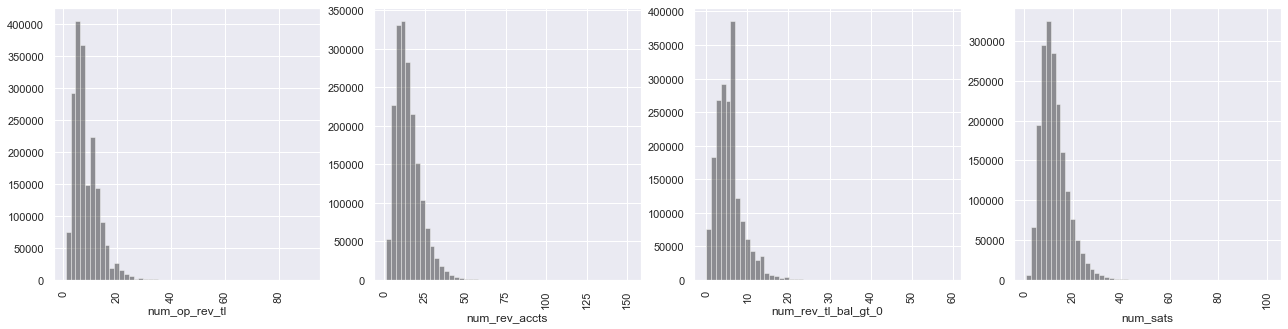

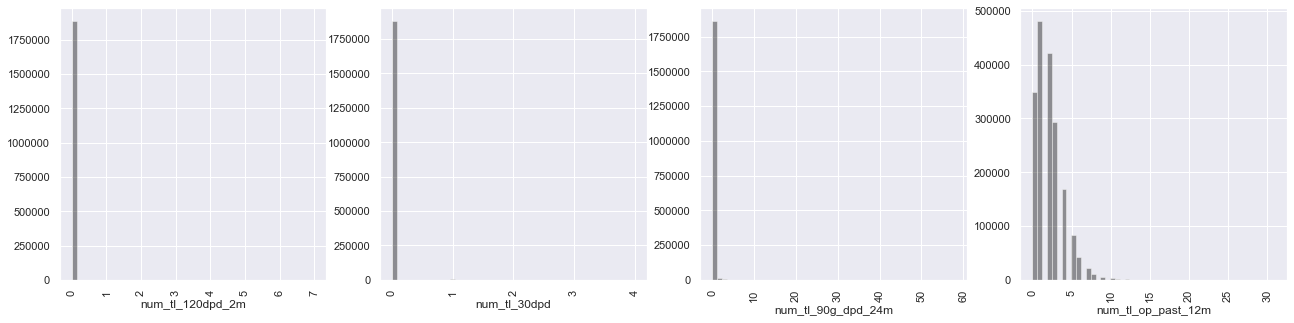

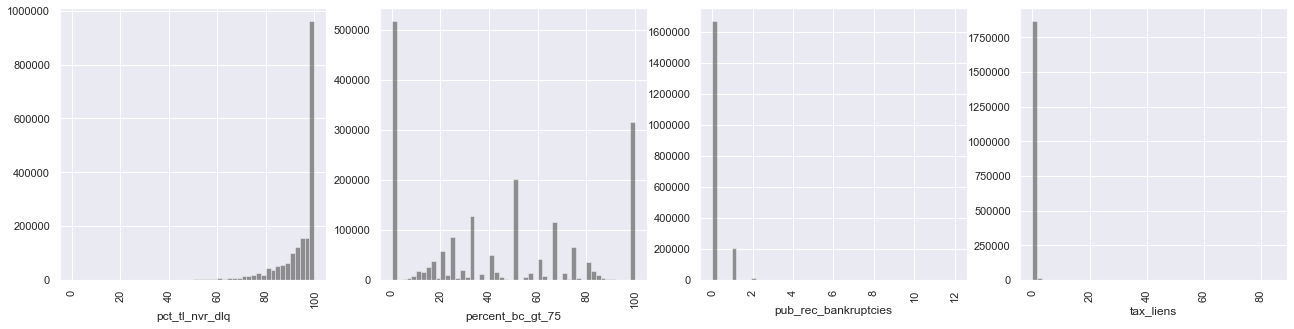

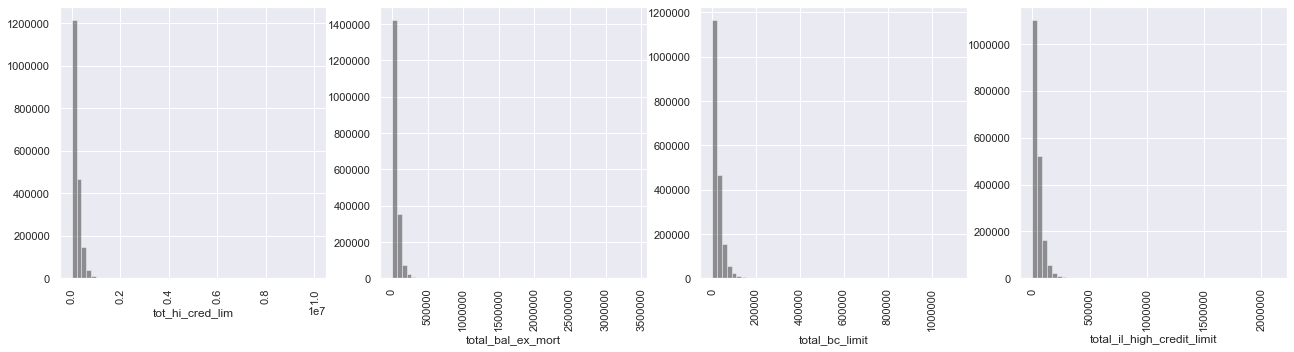

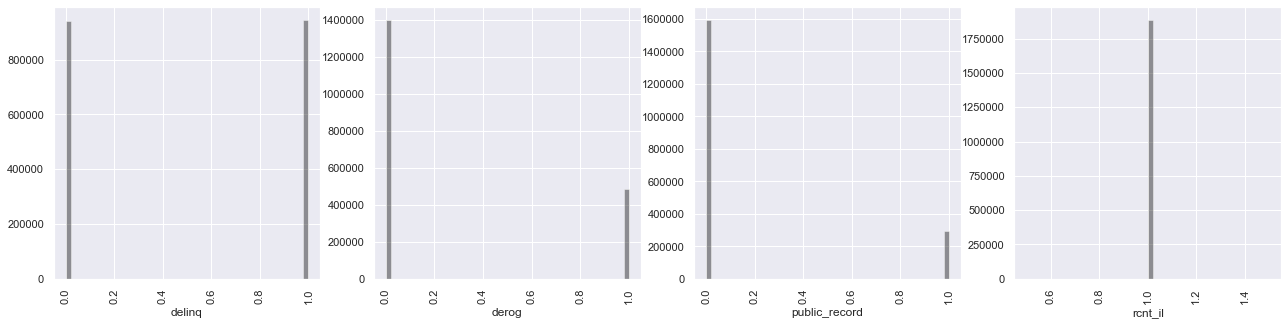

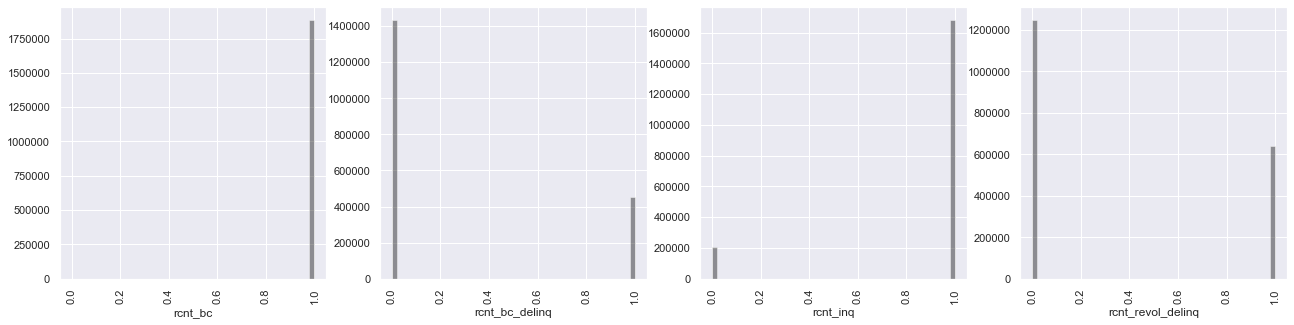

In [28]:
for i in split_num_cols:
    fig, axes = plt.subplots(ncols=len(i), figsize=(22,5))
    for ax, col in zip(axes, i):
        sns.set(style='darkgrid')
        sns.distplot(df[col], ax=ax, color='black', kde=False)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
    plt.show()

### As I supected from the initial review of the summary statistics, the frequency distributions are heavily skewed to the right. The presence of many outliers will probably mean using robust scaling instead of standard scaling during the preprocessing stage. In addition, a lot of the numerical columns are in fact binary indicating that they're a categorical. This won't need to be addressed as since they're already encoded as 1s and 0s, they can be left as they are.

# Bivariate Analysis

### Correlation between columns:

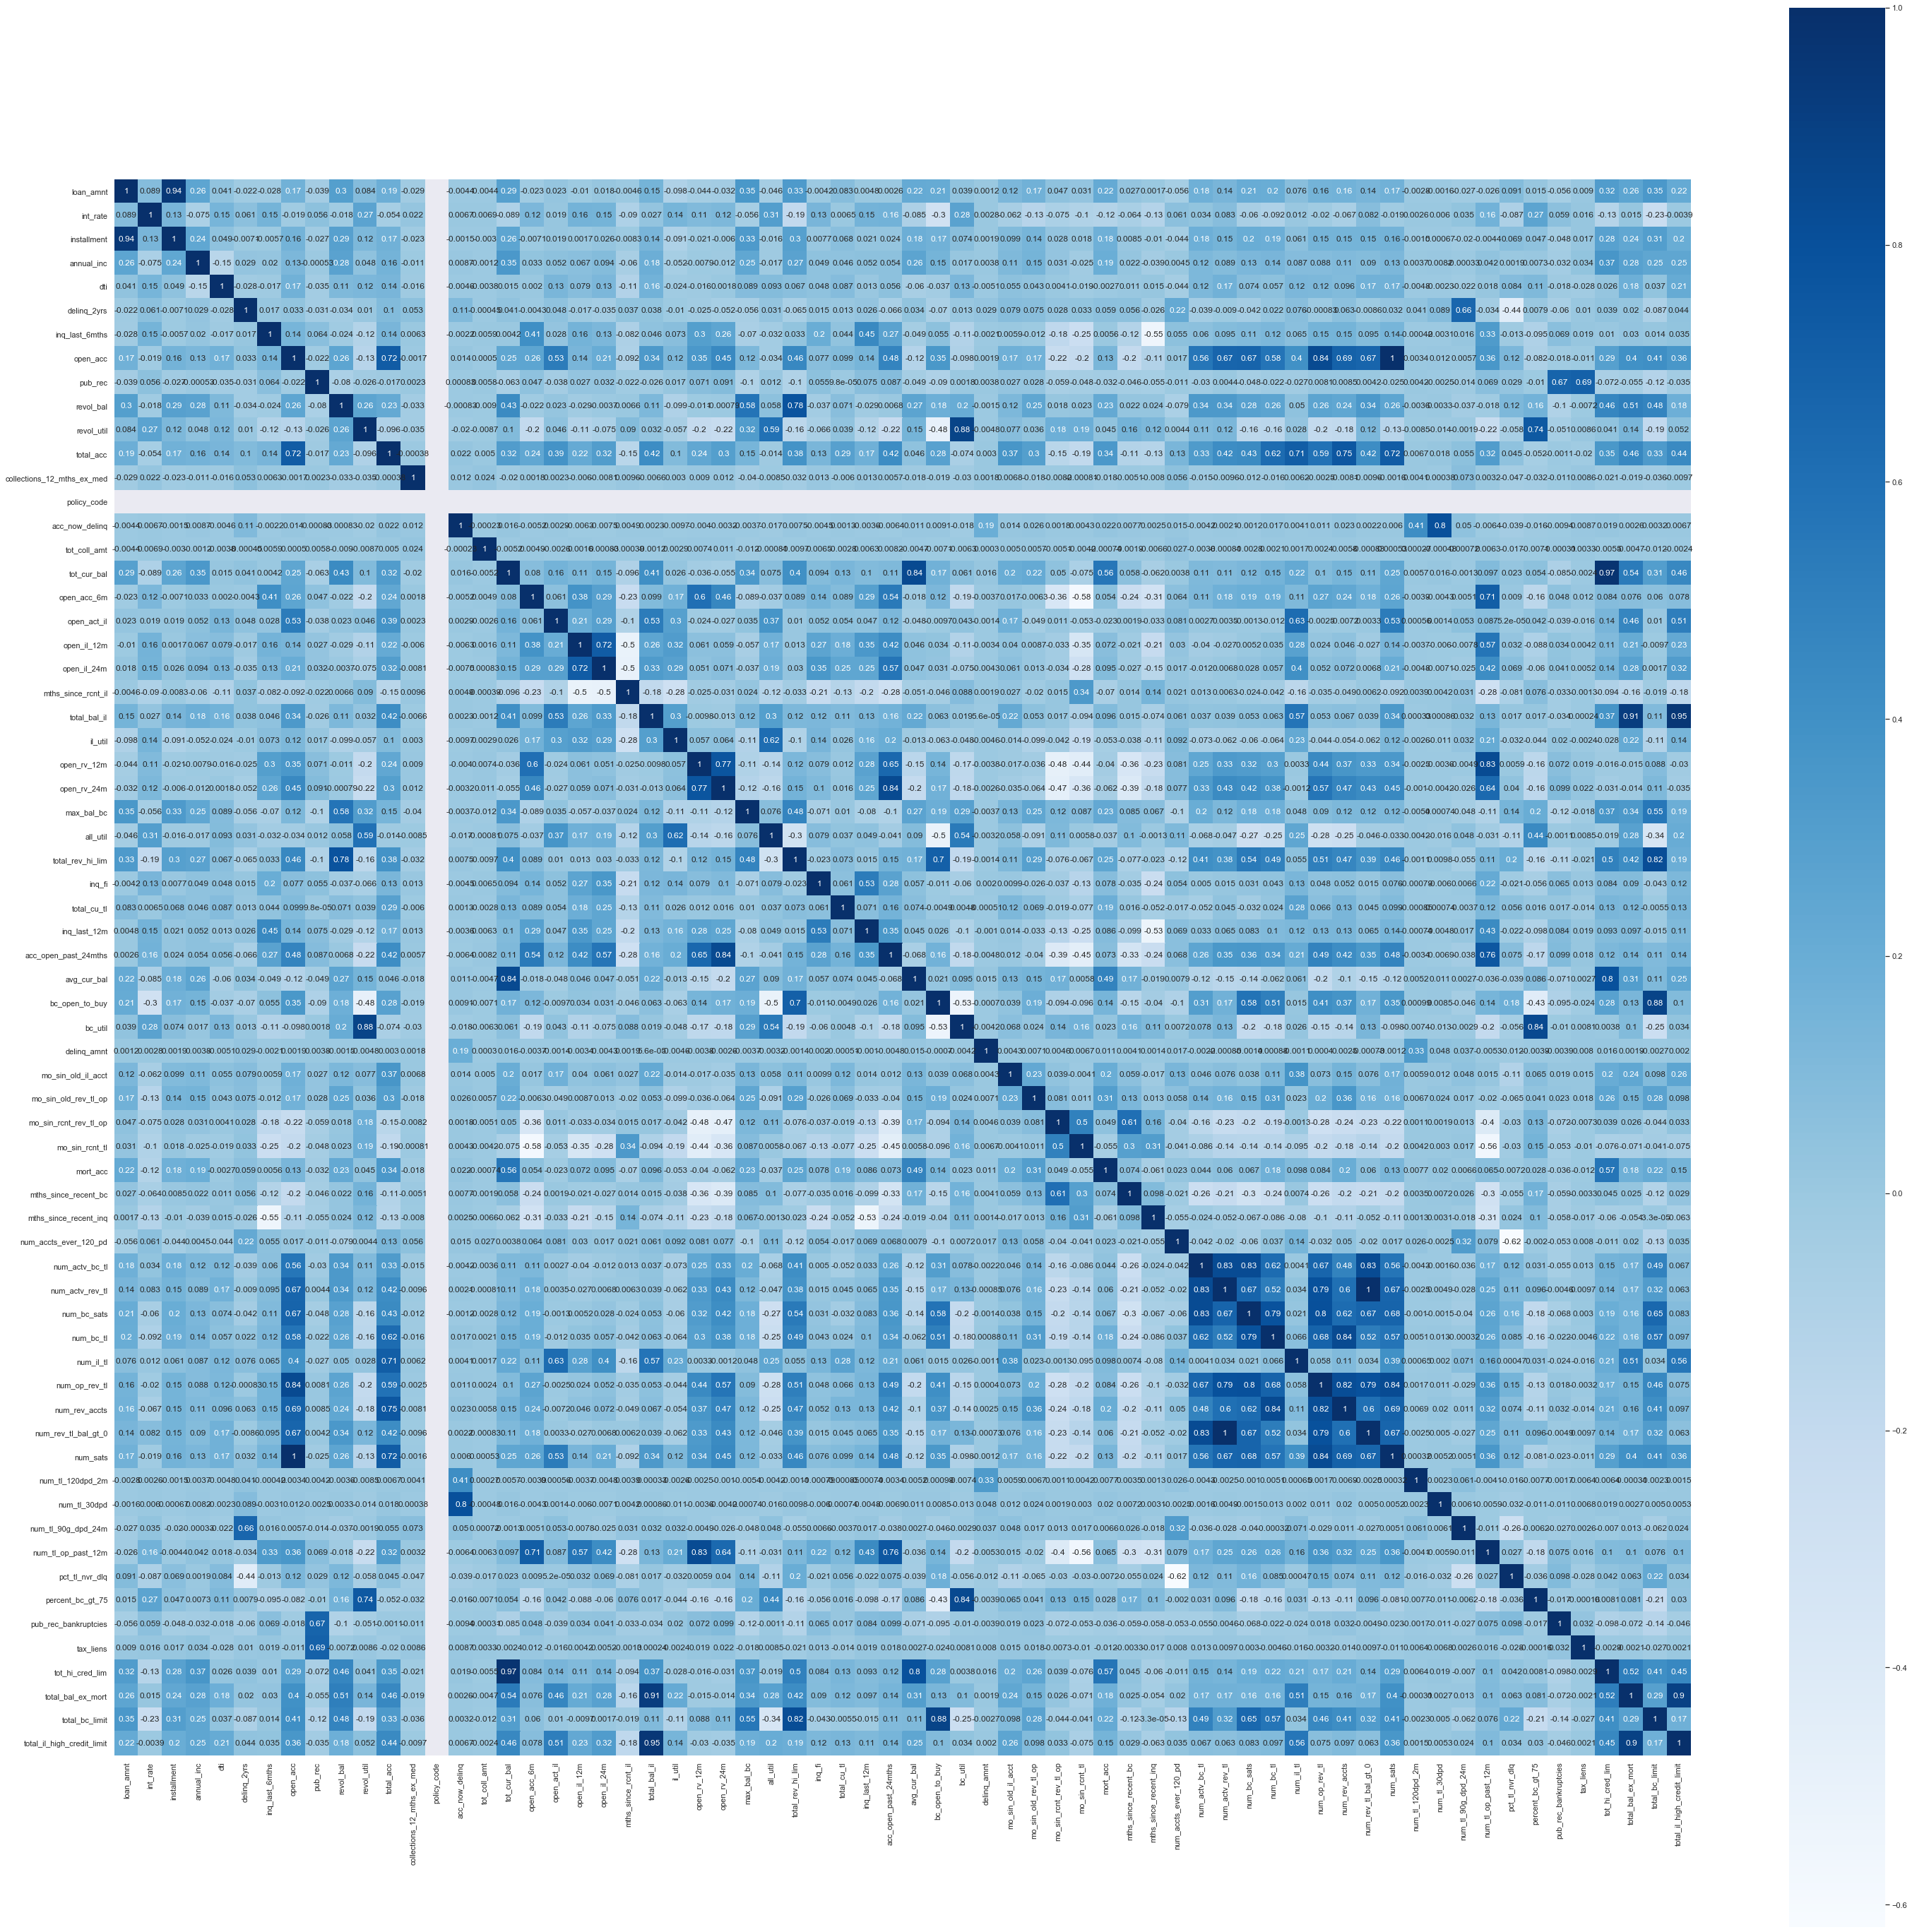

In [20]:
plt.figure(figsize=(50,50))
sns.heatmap(df_num.corr(),cmap='Blues',annot=True,square=True)
plt.show()

### A cursory view of the correlation heatmap shows that for the most part all the columns of the dataseta are independent of each of other. There are sporadic instances where the correlation values jump up past 70%, and there appears to be a cluster of correlated features involving the "revolving" credit columns. Most of these will probably be dropped in favor of one "revolving" credit column. 

In [31]:
df['loan_status'].replace(to_replace='Non-Default', value=0, inplace=True)
df['loan_status'].replace(to_replace='Default', value=1, inplace=True)

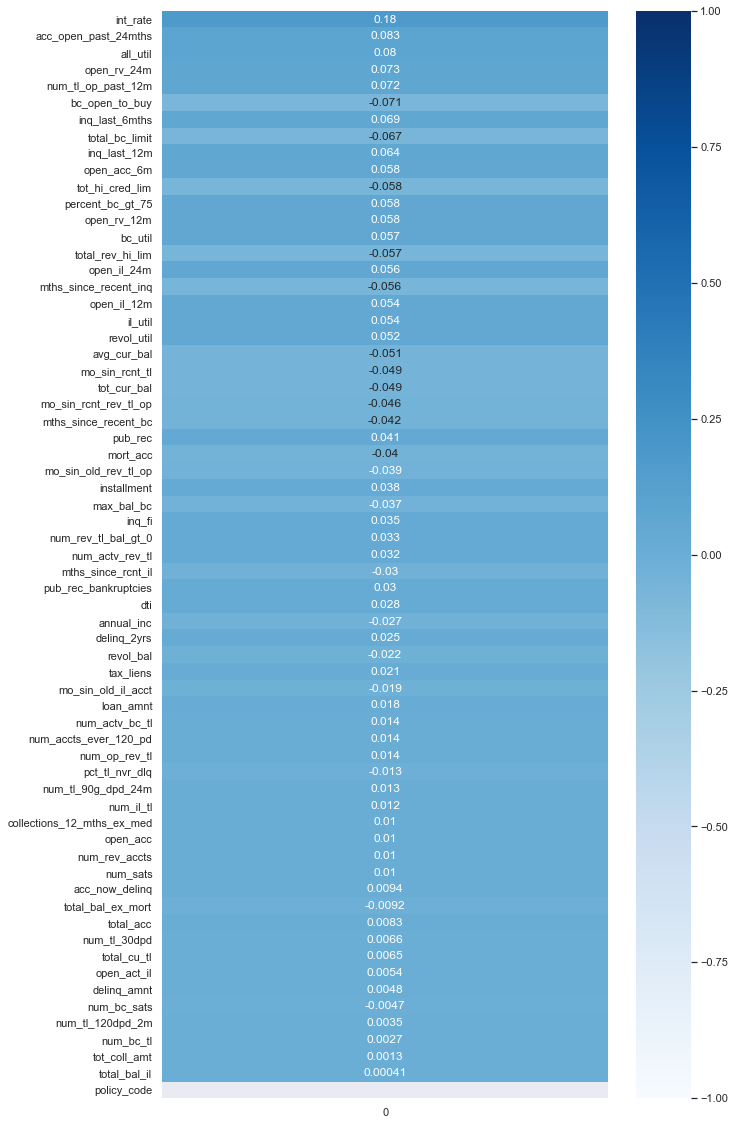

In [22]:
correlations = df_num.corrwith(df['loan_status']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), cmap='Blues', annot=True, vmin=-1, vmax=1, ax=ax);

### A brief analysis of the pearson correlations between the numeric columns and defaults do not appear to demonstrate high levels of correlation. Contrary to my immediate reaction, this is probably a good thing as it demonstrates that there are no columns leaking data into the target variable. Also, pearson correlations are notoriously insufficient in capturing the totality of relationships between continuous variables and a binary target.